# 환경설정

In [1]:
import matplotlib.pyplot as plt

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 라이브러리 

In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.dates as mdates

# 핵심 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# 데이터 확인
- 전통적인 시계열 데이터는 2개의 필드만 존재
  + 날짜, 데이터(e.g 매출, 온도, 요금..) 

In [5]:
DATA_PATH = './data/'

df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [7]:
# 날짜 형변환 방식 기억
df['year'] = pd.DatetimeIndex(df['date']).year
df.head(1)

,date,data,year
0,1960-01-01,0.71,1960


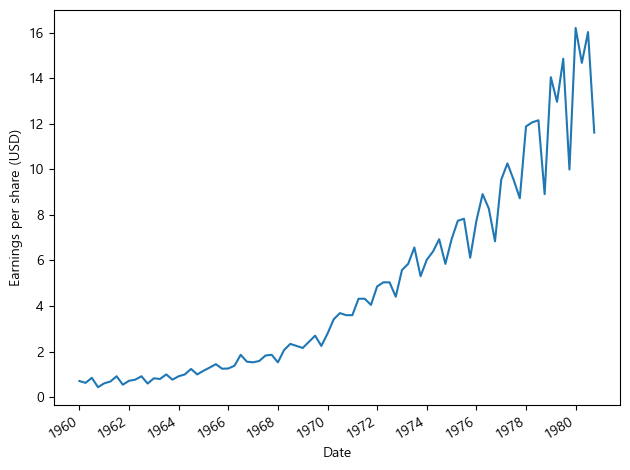

In [8]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

# 시계열 분해 및 시각화

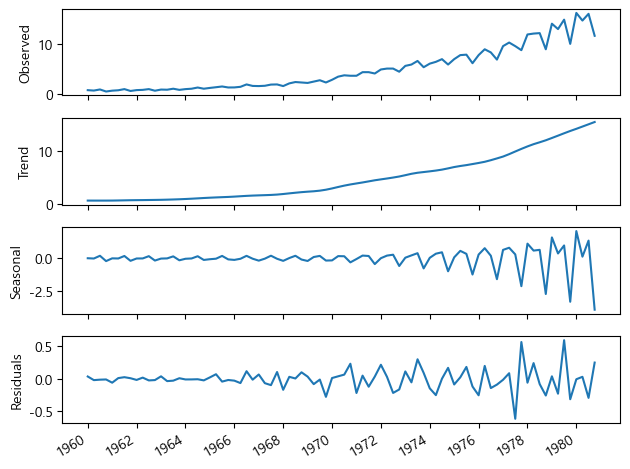

In [15]:
advanced_decomposition = STL(df['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 데이터 복원 
- 원래 상태로 복원

In [17]:
df.head()

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961


In [19]:
df = df.drop('year', axis = 1)
df.head(1)

KeyError: "['year'] not found in axis"

In [20]:
df.head(1)

,date,data
0,1960-01-01,0.71


In [22]:
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


# 베이스라인 모델 설계

## 예측구간 설정
- 머신러닝 vs. 시계열
  + 머신러닝 : 전체 데이터에서 무작위로 샘플링 해서 구분 (훈련데이터 / 테스트데이터)
    - 예측은 주어진 데이터를 생성
  + 시계열 : 먼과거 (훈련데이터) / 가장 최근 과거 (테스트데이터)
    - 훈련데이터 : 1960년 ~ 1979년
    - 테스트데이터 : 1980년
    - 예측 : 1981년 

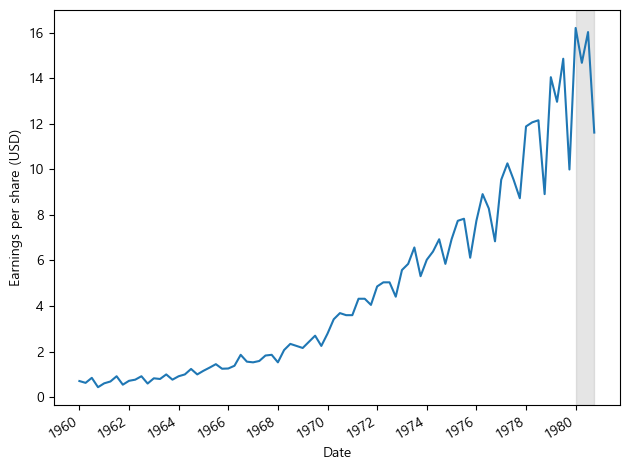

In [23]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 평가지표
- MAPE 함수 만들기, 라이브러리 메서드 활용 할 수 있음
- 권장사항
  + 공식을 보고 직접 수식을 만들어보는 것이 향후 공부 방법
  + 함수명 : mape()

In [24]:
def mape(y_true, y_pred):
    # y_true : 실젯값
    # y_pred : 예측값
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 데이터셋 분리
- 학습데이터 : 1960~1979
- 테스트데이터 : 1980
- 예측데이터 : 1981

In [25]:
train = df[:-4]
test = df[-4:]

train.shape, test.shape

((80, 2), (4, 2))

# 모델 비교
- 가장 좋은 모델을 찾는 과정
- 평가지표 함수를 최대한 활용
- 가장 좋은 모델을 활용해서 1981년 예측 

## 모델 1. Baseline 모델 (대조용)
- 19년 데이터의 평균 모델  

In [26]:
# 모델 학습 : 모델명 : 19년치 데이터의 평균
historical_mean = np.mean(train['data'])
historical_mean

np.float64(4.308499987499999)

In [28]:
# 예측 
test.loc[:, 'pred_mean'] = historical_mean
test

C:\Users\Admin\AppData\Local\Temp\ipykernel_21236\3952557168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = historical_mean


,date,data,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


In [29]:
# 평가지표 활용
mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean # 70% 오차가 발생하는 모델

np.float64(70.00752579965119)

### 예측 시각화 
- 실제 수치가 얼마나 큰 차이가 있는지 보여주는 용도

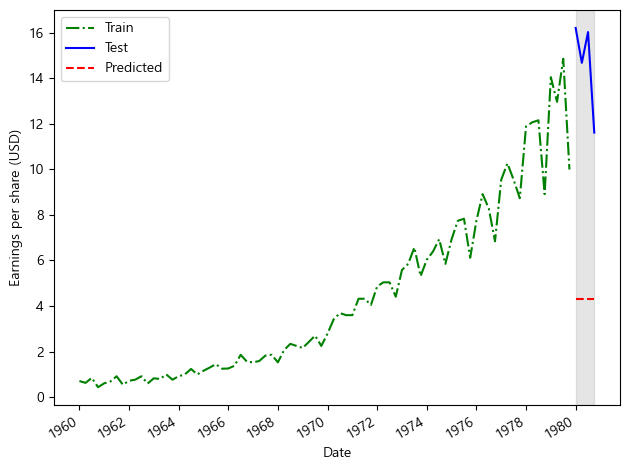

In [30]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모델 2. 최근 1년 데이터 활용한 모델
- 학습데이터와 테스트데이터와 구간이 같은 상황

In [32]:
last_year_mean = np.mean(train['data'][-4:]) # 모델 학습
test.loc[:, 'pred_last_yr_mean'] = last_year_mean # 테스트 데이터에 적용
test

C:\Users\Admin\AppData\Local\Temp\ipykernel_21236\4190284129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_yr_mean'] = last_year_mean


,date,data,pred_mean,pred_last_yr_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [33]:
# 모델 학습, 테스트, 평가 
mape_last_year_mean = mape(test['data'], test['pred_last_yr_mean'])
mape_last_year_mean

np.float64(15.5963680725103)

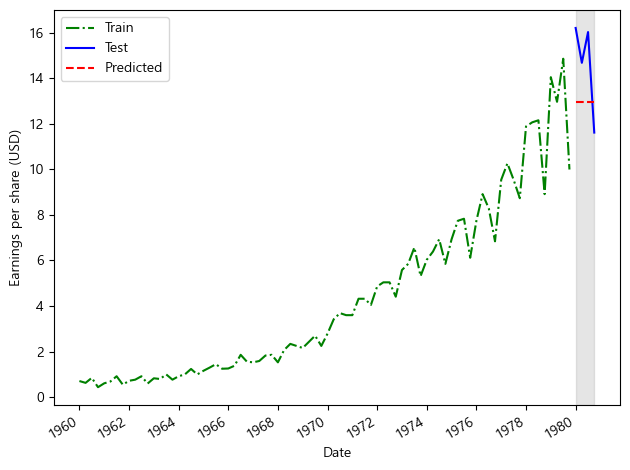

In [34]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모델 3. 계절성 예측 구현
- 주기적 패턴 확인

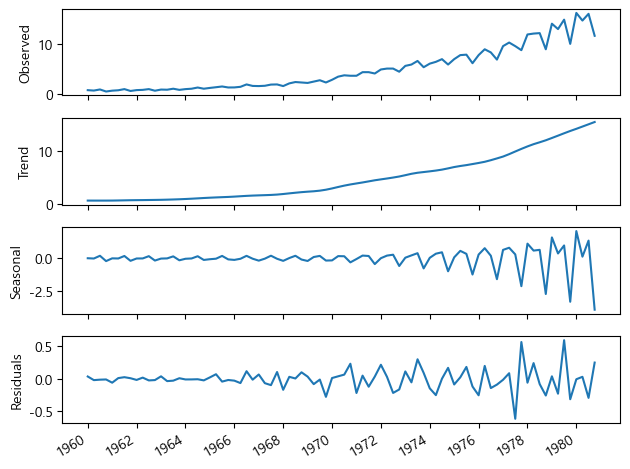

In [35]:
advanced_decomposition = STL(df['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

- 단순한 계절적 예측방법
  + 마지막으로 측정된 주기가 미래에도 반복된다. (최근 1년)
  + 1979년 첫 번째 분기의 EPS를 사용하여 1980년 첫번째 분기의 값 예측

In [41]:
test.loc[:, 'pred_last_season'] = train['data'][-4:].values # 모델 학습과 테스트 데이터 적용

# 학습, 테스트, 평가지표
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

np.float64(11.561658552433654)

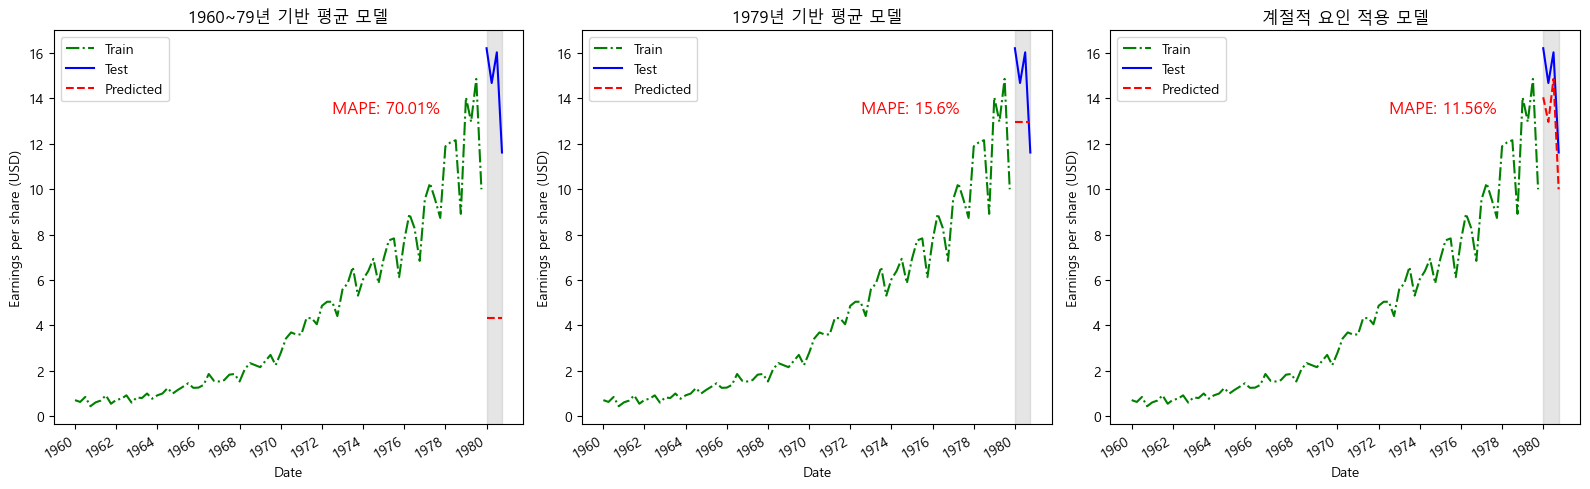

In [42]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))

# Plot for 1960~79 mean model
ax[0].plot(train['date'], train['data'], 'g-.', label='Train')
ax[0].plot(test['date'], test['data'], 'b-', label='Test')
ax[0].plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax[0].set_title('1960~79년 기반 평균 모델')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Earnings per share (USD)')
ax[0].axvspan(80, 83, color='#808080', alpha=0.2)
ax[0].legend(loc=2)
ax[0].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[0].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_hist_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[1].plot(train['date'], train['data'], 'g-.', label='Train')
ax[1].plot(test['date'], test['data'], 'b-', label='Test')
ax[1].plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')
ax[1].set_title('1979년 기반 평균 모델')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Earnings per share (USD)')
ax[1].axvspan(80, 83, color='#808080', alpha=0.2)
ax[1].legend(loc=2)
ax[1].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[1].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_last_year_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[2].plot(train['date'], train['data'], 'g-.', label='Train')
ax[2].plot(test['date'], test['data'], 'b-', label='Test')
ax[2].plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax[2].set_title('계절적 요인 적용 모델')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Earnings per share (USD)')
ax[2].axvspan(80, 83, color='#808080', alpha=0.2)
ax[2].legend(loc=2)
ax[2].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[2].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_naive_seasonal, 2)}%", color='red', fontsize=12)

# Format date labels and save the figure
fig.autofmt_xdate()
plt.tight_layout()
plt.show()